In [7]:
import numpy as np
from astropy.table import Table, join
from matplotlib import pyplot as plt

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import Span, HoverTool, ColumnDataSource
from bokeh.layouts import gridplot

from parse_sn_data import MASTER_TABLE as master_table

output_notebook()
_basic_tools = "save,pan,box_zoom,reset,wheel_zoom".split(',')


Loading BokehJS ...

In [8]:
# Get SDSS fit data
smp_fit_params = master_table[
    'CID',
    'x0SALT2zspec', 
    'x0errSALT2zspec', 
    'x1SALT2zspec', 
    'x1errSALT2zspec', 
    'cSALT2zspec', 
    'cerrSALT2zspec']

smp_fit_params.rename_column('CID', 'cid')
smp_fit_params.rename_column('x0SALT2zspec', 'x0_sdss')
smp_fit_params.rename_column('x0errSALT2zspec', 'x0_sdss_err')
smp_fit_params.rename_column('x1SALT2zspec', 'x1_sdss')
smp_fit_params.rename_column('x1errSALT2zspec', 'x1_sdss_err')
smp_fit_params.rename_column('cSALT2zspec', 'c_sdss')
smp_fit_params.rename_column('cerrSALT2zspec', 'c_sdss_err')

# Get SNCosmo fitt data
sncosmo_fits = Table.read('sncosmo_results/snia_all_bands/summary.csv')

sncosmo_fits.rename_column('x0', 'x0_ugriz')
sncosmo_fits.rename_column('x0_err', 'x0_err_ugriz')
sncosmo_fits.rename_column('x1', 'x1_ugriz')
sncosmo_fits.rename_column('x1_err', 'x1_err_ugriz')
sncosmo_fits.rename_column('c', 'c_ugriz')
sncosmo_fits.rename_column('c_err', 'c_err_ugriz')

# Calculate residuals
combined_table = join(sncosmo_fits, smp_fit_params)
combined_table = combined_table[~combined_table['x0_sdss'].mask]
for value in ('x0', 'x1', 'c'):
    combined_table['delta_' + value] = \
        100 * (combined_table[value + '_sdss'] - combined_table[value + '_ugriz']) / combined_table[value + '_sdss']


# Compare fit parameters between SNCosmo and SDSS

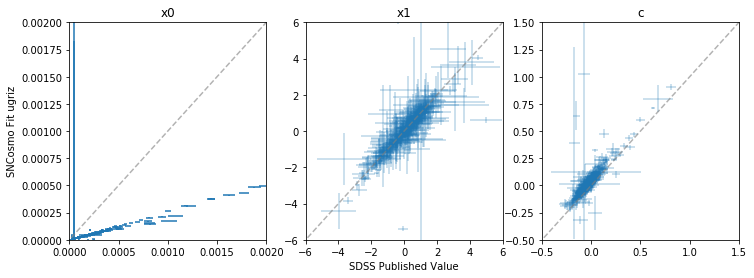

In [9]:
fit_data = combined_table[combined_table['class'] == 'SNIa']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
line = np.arange(-20, 20)

axes[0].plot(line, line, linestyle='--', color='grey', alpha=.6)
axes[0].errorbar(fit_data['x0_sdss'], fit_data['x0_ugriz'], 
                 xerr=fit_data['x0_sdss_err'], yerr=fit_data['x0_err_ugriz'], 
                 linestyle='')

axes[0].set_ylabel('SNCosmo Fit ugriz')
axes[0].set_title('x0')
axes[0].set_xlim(0, .002)
axes[0].set_ylim(0, .002)

axes[1].plot(line, line, linestyle='--', color='grey', alpha=.6)
axes[1].errorbar(fit_data['x1_sdss'], fit_data['x1_ugriz'],
                 xerr=fit_data['x1_sdss_err'], yerr=fit_data['x1_err_ugriz'], 
                 linestyle='', alpha=.3)

axes[1].set_xlabel('SDSS Published Value')
axes[1].set_title('x1')
axes[1].set_xlim(-6, 6)
axes[1].set_ylim(-6, 6)

axes[2].plot(line, line, linestyle='--', color='grey', alpha=.6)
axes[2].errorbar(fit_data['c_sdss'], fit_data['c_ugriz'],
                 xerr=fit_data['c_sdss_err'], yerr=fit_data['c_err_ugriz'], 
                 linestyle='', alpha=.3)

axes[2].set_title('c')
axes[2].set_xlim(-.5, 1.5)
axes[2].set_ylim(-.5, 1.5)

plt.show()



In [10]:
data_dict = {col.name: np.array(col) for col in fit_data.itercols()}
source = ColumnDataSource(data=data_dict)

hover = HoverTool(tooltips=[
        ("target", "@cid"),
        ("class", "@class"),
        ("z", "@z"),
        ('z_fit', '@fit_z'),
        ('chi2', '@chi'),
        ('dof', '@dof'),
    ])


In [11]:
figures = []
for value in ('x0', 'x1', 'c'):
    fig = figure(tools=_basic_tools + [hover, 'box_select', 'lasso_select'], title=value)
    fig.circle(value + '_ugriz', value + '_sdss', source=source, size=4, alpha=.5)
    fig.xaxis.axis_label = value + ' snc'
    fig.yaxis.axis_label = value + ' smp'
    figures.append(fig)

grid = gridplot(figures, ncols=3, plot_width=300, plot_height=300)
show(grid)


In [6]:
figures = []
for value in ('x0', 'x1', 'c'):
    fig = figure(tools=_basic_tools + [hover, 'box_select', 'lasso_select'], title=value)
    fig.circle('z', 'delta_' + value, source=source, size=4, alpha=.5)
    fig.xaxis.axis_label = 'Redshift'
    fig.yaxis.axis_label = 'Percent Residual'
    figures.append(fig)

grid = gridplot(figures, ncols=3, plot_width=325, plot_height=325)
show(grid)
